# ASSIGNMENT_2_1_RT - INTERACTIVE CLIENT NODE

### Imports, ROS initialization and global variable setup

This cell imports essential ROS, plotting, and widget libraries required for robot control, state monitoring, and visualization. It also defines global variables for odometry data, action client, and plotting widgets, laying the groundwork for robot planning and interaction in the notebook.

In [ ]:
import rospy
import time
import actionlib
import sys
import math
from sensor_msgs.msg import LaserScan
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Pose, Twist, PoseStamped
from actionlib_msgs.msg import GoalStatus

from assignment2_1_rt.msg import PosVel, PlanningAction, PlanningGoal

import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import HBox, VBox

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation as FAnim

#______________________REQUIRED GLOBAL VARIABLES______________________
#Standard required global variables
OdPose = Pose()
OdTwist = Twist()
client = None
pub_PsVl = None

min_obstacle_distance = widgets.FloatText(value=0.0, description='closest obstacle [m]:', disabled=True)

#Output plot global variables
goal_output = widgets.Output()
output_ClientServer = widgets.Output()

### ROS Callbacks for Odometry, Position, and Laser Scan

This cell defines ROS callback functions to manage and publish the robot's state. The `odom_callback` updates global variables with the robot's current pose and velocity from odometry data. The `pos_callback` publishes a custom message containing position and velocity values if the publisher is initialized. The `scan_callback` processes laser scan data from the `/scan` topic (which provides LaserScan messages containing an array of range values) to determine and update the distance to the nearest valid obstacle, filtering out invalid readings (such as zero, infinity, or NaN) and determines the closest valid distance by taking the minimum (each time a message is received).

In [ ]:
def odom_callback(msg):
    global OdPose, OdTwist
    OdPose = msg.pose.pose
    OdTwist = msg.twist.twist

def pos_callback(event=None):
    global OdPose, OdTwist, pub_PsVl
    if pub_PsVl:
        msg = PosVel()
        msg.pos_x = OdPose.position.x
        msg.pos_y = OdPose.position.y
        msg.vel_x = OdTwist.linear.x
        msg.vel_z = OdTwist.angular.z
        pub_PsVl.publish(msg)
        
def scan_callback(msg):
    global min_obstacle_distance
    
    valid_ranges = [r for r in msg.ranges if r > 0.01 and not rospy.is_shutdown() and not (math.isinf(r))]
    if valid_ranges:
        min_obstacle_distance.value = min(valid_ranges)
    else:
        min_obstacle_distance.value = None

### Goal Management and Feedback Handling

This cell defines functions to manage goal communication with the ROS action server. The `feedback_clbk` function processes feedback from the server, updating the count of reached goals and printing the current status. The `send_goal` function sends a new goal to the action server if none is currently active, using user-defined target coordinates. The `cancel_goal` function attempts to cancel an active or pending goal, updating the failure count if the cancellation is successful.

In [ ]:
def feedback_clbk(feedback):
    global reached_count
    with goal_output:
        if (feedback.stat == "Target reached!"):
            reached_count += 1
            clear_output(wait=True)
            print("Target reached\n{}\nStatus: {}\n".format(feedback.actual_pose, feedback.stat))

def send_goal(_):
    global client
    with goal_output:
        clear_output(wait=True)
        if not client.get_state() in [GoalStatus.ACTIVE, GoalStatus.PENDING]:

            target = PoseStamped()
            target.pose.position.x = x_input.value
            target.pose.position.y = y_input.value

            goal = PlanningGoal()
            goal.target_pose = target

            client.send_goal(goal, feedback_cb = feedback_clbk)
            print(f"Sent goal: ({target.pose.position.x}, {target.pose.position.y})")
        else:
            print("Goal already sent")
            
def cancel_goal(_):
    global client, failed_count
    with goal_output:
        clear_output(wait=True)
        if client.get_state() in [GoalStatus.ACTIVE, GoalStatus.PENDING]:
            client.cancel_goal()
            rospy.sleep(1)
            state = client.get_state()
            if state in [GoalStatus.PREEMPTED, GoalStatus.RECALLED]:
                print('Goal canceled')
                failed_count += 1
            else:
                print("Can't clear current goal")
        else:
            print("No active goal")

### ROS Node Initialization and Topic Subscription

This cell initializes the ROS node and sets up communication channels. It creates a publisher for position and velocity data, subscribes to the `/odom` and `/scan` topics for robot state and obstacle data, and connects to the `/reaching_goal` action server. It also starts a timer to periodically publish the robot's position and velocity, ensuring the system is ready for interaction. A try-except block handles potential ROS interruptions gracefully.

In [ ]:
def init_ros_node():
    global client, pub_PsVl
    rospy.init_node('interactive_action_client')
    
    pub_PsVl = rospy.Publisher("/posVel", PosVel, queue_size=10)
    
    with output_ClientServer:
        rospy.loginfo("---Checking '\odom' topic---")
    rospy.wait_for_message('/odom', Odometry)
    rospy.Subscriber("/odom", Odometry, odom_callback)
    
    with output_ClientServer:
        rospy.loginfo("---Checking '\scan' topic---")
        rospy.wait_for_message("/scan", LaserScan)
    rospy.Subscriber("/scan", LaserScan, scan_callback)
    
    client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
    with output_ClientServer:
        rospy.loginfo("---Waiting for action server---")
        
    client.wait_for_server()
    with output_ClientServer:
        rospy.loginfo("---Action server connected---")
        rospy.loginfo("---SYSTEM READY---")
    rospy.Timer(rospy.Duration(0.5), pos_callback)

        
try:
    init_ros_node()
except rospy.ROSInterruptException:
    print("ROS Interrupt Exception detected")

In [ ]:
#display(output_ClientServer)

### Goal Input and Control Widget Setup

This cell creates interactive widgets for user input and goal control. It defines float text fields for entering X and Y target coordinates, and buttons for sending or canceling goals. The widgets are displayed in a structured layout and linked to their respective callback functions to trigger goal-related actions.

In [18]:
x_input = widgets.FloatText(value=0.0, description='X:', step=0.1)
y_input = widgets.FloatText(value=0.0, description='Y:', step=0.1)

send_button = widgets.Button(description='Send Goal', button_style='success')
cancel_button = widgets.Button(description='Canceal Goal', button_style='danger')

#display(widgets.VBox([x_input, y_input]))
#display(widgets.VBox([send_button, cancel_button]))
commands = widgets.VBox([x_input, y_input])
buttons = widgets.VBox([send_button, cancel_button])
display(widgets.HBox([commands, buttons]))
send_button.on_click(send_goal)
cancel_button.on_click(cancel_goal)

#display(goal_output)
title_1 = widgets.Label("Client/Server and ROS Output")
title_2 = widgets.Label("Control Output")
#_____________________________________________________
col_1 = widgets.VBox([title_1, output_ClientServer])
col_2 = widgets.VBox([title_2, goal_output])
#_____________________________________________________
display(widgets.HBox([col_1, col_2]))

#display(widgets.HBox([output_ClientServer, goal_output]))

In [19]:
#display(goal_output)
#title_1 = widgets.Label("Client/Server and ROS Output")
#title_2 = widgets.Label("Control Output")
#_____________________________________________________
#col_1 = widgets.VBox([title_1, output_ClientServer])
#col_2 = widgets.VBox([title_2, goal_output])
#_____________________________________________________
#display(widgets.HBox([col_1, col_2]))

#display(widgets.HBox([output_ClientServer, goal_output]))

### Robot Position Visualization and Trace Control and Display Minimum Obstacle Distance

This cell sets up a real-time 2D plot to visualize the robot’s position and movement trace using `matplotlib`. It initializes the figure, robot marker, and trace line, with controls to toggle or reset the trace via interactive widgets. A `FuncAnimation` object updates the plot at regular intervals by reading the robot’s current position from odometry data. The user can enable, disable, or reset the trace using the dropdown and button widgets.
This line displays the minimum obstacle distance, which is updated by the `scan_callback()` function based on the robot's laser scan data. The displayed value represents the closest detected obstacle, providing real-time feedback on the robot's environment.

<IPython.core.display.Javascript object>


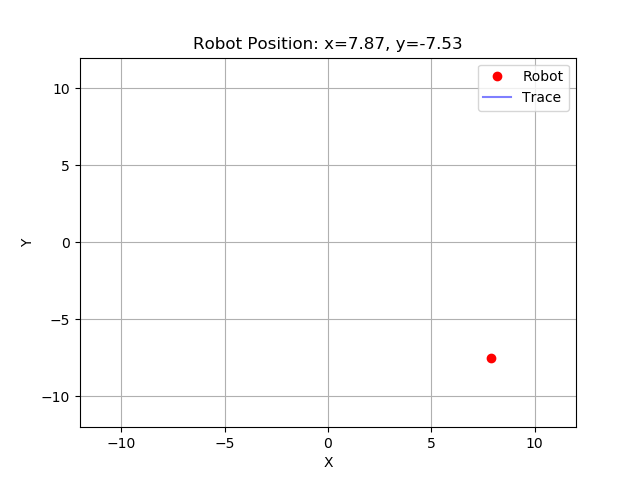

FloatText(value=1.095207691192627, description='closest obstacle [m]:', disabled=True)

In [25]:
%matplotlib notebook
fig, ax = plt.subplots()
robot_pos, = ax.plot([], [], 'ro', label='Robot')
trace_line, = ax.plot([], [], 'b-', alpha=0.5, label='Trace')

ax.set_xlim(-12, 12)
ax.set_ylim(-12, 12)
ax.grid(True)
ax.legend()
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Global variables used for the trace
trace_enabled = True
trace_visible = True
trace_x = []
trace_y = []

def on_trace_mode_change(change): # Dropdown menu definition
    global trace_enabled, trace_visible
    mode = change['new']
    if mode == 'Keep trace':
        trace_enabled = True
        trace_visible = True
    elif mode == 'Disable trace':
        trace_enabled = False
        trace_visible = False
        trace_line.set_data([], [])
        
def reset_trace(_): # Reset button function to clean the trace
    global trace_x, trace_y
    trace_x.clear()
    trace_y.clear()
    trace_line.set_data([], [])

def init_function():
    trace_line.set_data([],[])
    robot_pos.set_data([],[])
    return (trace_line, robot_pos)

def update_trace(frame):
    global trace_enabled, trace_visible, trace_x, trace_y, ax, robot_pos
    
    x = OdPose.position.x
    y = OdPose.position.y
    robot_pos.set_data(x, y) #to plot position
    
    ax.set_title(f"Robot Position: x={x:.2f}, y={y:.2f}") #to display current position
    
    if trace_enabled:
            trace_x.append(x)
            trace_y.append(y)
    if trace_visible:
        trace_line.set_data(trace_x, trace_y) #to plot trace
    
    ax.relim()
    ax.autoscale_view()
    return (trace_line, robot_pos)

trace_mode_dropdown = widgets.Dropdown( # Dropdown menu init
    options=['Keep trace','Disable trace'],
    value='Keep trace',
    description='Trace:'
)

reset_button = widgets.Button(description='Reset', button_style='info') #trace-reset button init

trace_mode_dropdown.observe(on_trace_mode_change, names='value') # Connect callbacks
reset_button.on_click(reset_trace)

display(widgets.HBox([trace_mode_dropdown, reset_button]))
display(min_obstacle_distance)
RobPosAnim = FAnim(fig, update_trace, init_func=init_function, interval=500, blit=True)

### Goal Outcome Visualization

This cell sets up a bar chart to visualize the number of reached and non-reached targets. It initializes a bar plot with two bars—one for successful goals and one for failed goals—and dynamically updates the bars in real-time using `FuncAnimation`. The bar heights reflect the current counts of reached and failed goals, providing a live summary of the robot's goal achievement status.

<IPython.core.display.Javascript object>


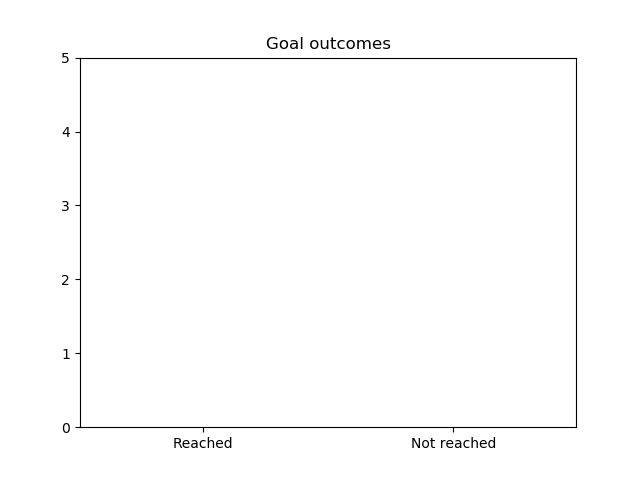

In [29]:
#Variables for reached/non-reached targets
reached_count, failed_count = 0, 0

fig_bars, ax_bars = plt.subplots()
bars = ax_bars.bar(['Reached', 'Not reached'], [0, 0], color=['blue', 'red'])
ax_bars.set_title("Goal outcomes")
ax_bars.set_ylim(0, max(5, reached_count + reached_count + 1))

def update_bars(frame):
    bars[0].set_height(reached_count)
    bars[1].set_height(failed_count)
    tot = reached_count + failed_count
    #ax_bars.set_ylim(0, max(5, tot + 1))
    ax_bars.set_ylim(0, max(5, reached_count, failed_count))
    return bars

count_bars_plot = FAnim(fig_bars, update_bars, interval=500, blit=True)